## Character-level MLP text generator


**Goal:** Given a context window of `C` previous characters, predict the next character.
This notebook implements:
- character vocabulary & sliding-window dataset
- embedding lookup
- 2-layer MLP (ReLU) with manual gradients
- minibatch SGD training
- generation (sampling with temperature & top-k)


### Import configs


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
np.random.seed(42)


In [2]:
path = "data/alice.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

print("Total characters:", len(text))
print("Preview:", text[:300].replace("\n","\\n"))


Total characters: 148574
Preview: alice's adventures in wonderland\n\n                alice's adventures in wonderland\n\n                          lewis carroll\n\n               the millennium fulcrum edition 3.0\n\n\n\n\n                            chapter i\n\n                      down the rabbit-hole\n\n\n  alice was beginning to get very tir


We use a character-level vocabulary.  
We will convert chars → indices using `char2idx` and `idx2char`.


In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
# show characters (print invisibles in repr)
print("Sample chars:", chars[:50])

char2idx = {ch:i for i,ch in enumerate(chars)}
idx2char = {i:ch for ch,i in char2idx.items()}


Vocab size: 46
Sample chars: ['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create training pairs using a sliding window of length `C`:
- Input: last `C` characters (as indices)
- Target: next character index

We will store inputs as integer arrays (B, C) and targets as (B,)

Why Sliding Window?
 - MLP needs fixed-size input. Transformers and RNNs can process variable-length sequences,
but MLPs cannot

```
Text: a l i c e   w a s ...
Window size C=8:

Input: "alice wa" → Target: "s"
```

In [4]:
# hyperparams for dataset
C = 8  # context length (previous chars)
max_samples = None  # set to int to subsample for speed

# convert full text to list of indices
idxs = np.array([char2idx[ch] for ch in text], dtype=np.int32)

# build windows
N = len(idxs) - C
if max_samples is None or max_samples > N:
    N_samples = N
else:
    N_samples = max_samples

X = np.zeros((N_samples, C), dtype=np.int32)
y = np.zeros((N_samples,), dtype=np.int32)

# if subsampling, pick evenly to cover the text; else sequential
if N_samples == N:
    start_positions = np.arange(N)
else:
    start_positions = np.linspace(0, N-1, N_samples, dtype=int)

for i, pos in enumerate(start_positions):
    X[i] = idxs[pos:pos+C]
    y[i] = idxs[pos+C]

print("Dataset size:", X.shape[0])
print("Example (as chars):")
for i in range(3):
    s = "".join(idx2char[idx] for idx in X[i])
    t = idx2char[y[i]]
    print(f"  {repr(s)} -> {repr(t)}")


Dataset size: 148566
Example (as chars):
  "alice's " -> 'a'
  "lice's a" -> 'd'
  "ice's ad" -> 'v'


Model:
- Embedding matrix E: (vocab_size, emb_dim)
- Flatten embeddings for the context: x_flat shape (C*emb_dim,)
- Linear layer 1: x_flat @ W1 + b1  -> hidden (H,)
- ReLU
- Linear layer 2: hidden @ W2 + b2 -> logits (vocab_size,)
- Softmax -> distribution over next char

We will implement manual gradients for all parameters including embedding updates.


chars → indices → embeddings → flatten → MLP → logits → softmax → probabilities



```chars → indices → embeddings → flatten → MLP → logits → softmax → probabilities
```

In [6]:
# model hyperparams
emb_dim = 16
H = 128

# parameters
E = np.random.randn(vocab_size, emb_dim) * 0.01  # embeddings
W1 = np.random.randn(C * emb_dim, H) * (1.0 / np.sqrt(C * emb_dim))
b1 = np.zeros(H)
W2 = np.random.randn(H, vocab_size) * (1.0 / np.sqrt(H))
b2 = np.zeros(vocab_size)



In [7]:
def softmax_logits(logits):
    # logits: (B, V)
    ex = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

def cross_entropy_loss(probs, targets):
    # probs: (B, V) ; targets: (B,)
    N = targets.shape[0]
    correct = probs[np.arange(N), targets]
    return -np.mean(np.log(correct + 1e-12))

We will train with minibatch SGD. For each batch:
1. Lookup embeddings: E[X] -> (B, C, emb_dim)
2. Flatten -> x_flat (B, C*emb_dim)
3. Forward: x_flat -> hidden (ReLU) -> logits -> probs
4. Loss: cross-entropy
5. Backpropagate manually:
   - dlogits = (probs - y_onehot) / B
   - compute gradients for W2, b2, W1, b1
   - compute gradient for embeddings and scatter-add into E
6. Update params with simple SGD


In [8]:
# training hyperparams
lr = 0.5
batch_size = 512
epochs = 20

num_samples = X.shape[0]
steps_per_epoch = max(1, num_samples // batch_size)

loss_history = []



In [9]:
for epoch in range(1, epochs+1):
    # shuffle dataset each epoch
    perm = np.random.permutation(num_samples)
    X_shuf = X[perm]
    y_shuf = y[perm]
    epoch_loss = 0.0

    for step in range(steps_per_epoch):
        i0 = step * batch_size
        i1 = i0 + batch_size
        xb = X_shuf[i0:i1]        # shape (B, C)
        yb = y_shuf[i0:i1]        # shape (B,)

        B = xb.shape[0]

        # forward
        emb = E[xb]               # (B, C, emb_dim)
        x_flat = emb.reshape(B, C * emb_dim)  # (B, C*D)
        h_pre = x_flat.dot(W1) + b1            # (B, H)
        h = np.maximum(0, h_pre)               # ReLU
        logits = h.dot(W2) + b2                # (B, V)
        probs = softmax_logits(logits)         # (B, V)
        loss = cross_entropy_loss(probs, yb)
        epoch_loss += loss

        # backward
        # dlogits
        dlogits = probs.copy()
        dlogits[np.arange(B), yb] -= 1.0
        dlogits /= B                           # (B, V)

        # W2, b2
        dW2 = h.T.dot(dlogits)                 # (H, V)
        db2 = np.sum(dlogits, axis=0)          # (V,)

        # backprop into hidden
        dh = dlogits.dot(W2.T)                 # (B, H)
        dh_pre = dh * (h_pre > 0).astype(float)  # (B, H)  # ReLU grad

        # W1, b1
        dW1 = x_flat.T.dot(dh_pre)             # (C*D, H)
        db1 = np.sum(dh_pre, axis=0)           # (H,)

        # embeddings gradient (scatter add)
        dx_flat = dh_pre.dot(W1.T)             # (B, C*D)
        dE = np.zeros_like(E)                  # (V, D)
        dx_emb = dx_flat.reshape(B, C, emb_dim)  # (B, C, D)
        for bi in range(B):
            for ci in range(C):
                idx = xb[bi, ci]
                dE[idx] += dx_emb[bi, ci]

        # update params (SGD)
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
        E  -= lr * dE

    avg_epoch_loss = epoch_loss / steps_per_epoch
    loss_history.append(avg_epoch_loss)

    # print progress and sample some text occasionally
    if epoch % 1 == 0:
        print(f"Epoch {epoch}/{epochs} - loss: {avg_epoch_loss:.4f}")

        # sample short text to monitor progress
        seed = text[:C]
        from_random = False
        def sample_once(seed, length=200, temperature=1.0, top_k=None):
            out = seed
            cur = [char2idx[ch] for ch in seed]
            for _ in range(length):
                xb = np.array(cur[-C:], dtype=np.int32).reshape(1, C)
                emb = E[xb].reshape(1, C*emb_dim)
                h_pre = emb.dot(W1) + b1
                h = np.maximum(0, h_pre)
                logits = h.dot(W2) + b2
                logits = logits / temperature
                probs = np.exp(logits - logits.max()) 
                probs = probs / probs.sum()
                probs = probs.ravel()
                if top_k is not None:
                    filtered = np.argpartition(probs, -top_k)[-top_k:]
                    mask = np.ones_like(probs, dtype=bool)
                    mask[:] = False
                    mask[filtered] = True
                    probs = probs * mask
                    probs = probs / probs.sum()
                next_idx = np.random.choice(vocab_size, p=probs)
                out += idx2char[next_idx]
                cur.append(next_idx)
            return out

        print("  sample:", sample_once(seed=text[:C], length=150, temperature=1.0, top_k=10))


Epoch 1/20 - loss: 2.7367
  sample: alice's teat tore, ita inltous in thote wurd ther aneler
as wuut, o cad yant herat, ird alelgensint tir, to dradgatte deds, ouin as ohin bede teit oide douthe
Epoch 2/20 - loss: 2.2230
  sample: alice's all a kittle chime hithe
sored, whon sun on think alideres tan the samllatite
that.'n
hes, sowshe'
s she doued it ilor'n bery abt is ly waster afiredy
Epoch 3/20 - loss: 2.0389
  sample: alice's salding of and, yisthat the ser,' saige, ald waven wat cus her and wis
mouly wo that the madkly at she had gaid bent was
eres at the dosthed the gutti
Epoch 4/20 - loss: 1.9256
  sample: alice's ouck a the case mues, `i had
not but it me aleadd afowind onind
the dryen'n opsages, abdis to ceass at rep at thit mire carsing so to han in to the ki
Epoch 5/20 - loss: 1.8451
  sample: alice's wile catint it ablome thearion's
-u worn if.

                     sawe dowsle sain't a shame theres.

  the kotted ithere catting butsaint it to grie
Epoch 6/20 - loss: 1.7817

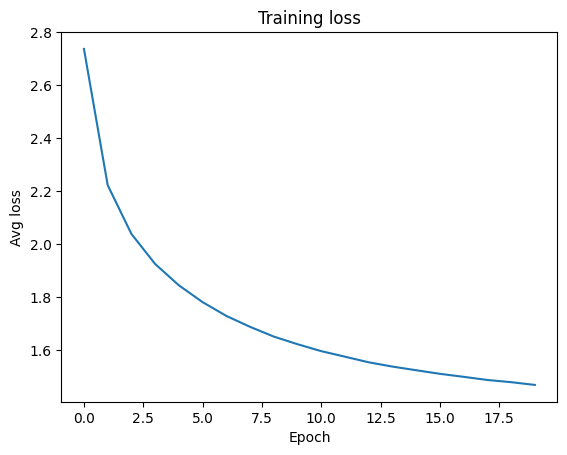

In [10]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Avg loss")
plt.title("Training loss")
plt.show()


Generation parameters:
- `start` string: initial seed text (length >= C recommended)
- `length`: number of characters to generate
- `temperature`: scaling on logits (higher => more random)
- `top_k`: only sample among top_k highest-prob tokens (optional)


In [ ]:
def generate_text(start, length=400, temperature=1.0, top_k=None):
    assert len(start) >= C, f"start must be at least {C} chars"
    out = start
    cur = [char2idx[ch] for ch in start]
    for _ in range(length):
        xb = np.array(cur[-C:], dtype=np.int32).reshape(1, C)
        emb = E[xb].reshape(1, C*emb_dim)
        h_pre = emb.dot(W1) + b1
        h = np.maximum(0, h_pre)
        logits = h.dot(W2) + b2
        logits = logits / max(1e-8, temperature)
        # softmax
        exp = np.exp(logits - logits.max())
        probs = exp / exp.sum()
        probs = probs.ravel()
        if top_k is not None:
            # keep only top_k
            inds = np.argpartition(probs, -top_k)[-top_k:]
            mask = np.zeros_like(probs, dtype=bool)
            mask[inds] = True
            probs = probs * mask
            probs = probs / probs.sum()
        next_idx = np.random.choice(vocab_size, p=probs)
        out += idx2char[next_idx]
        cur.append(next_idx)
    return out

print(generate_text(text[:C], length=300, temperature=0.8, top_k=8))


alice's no herself, `that pastion:' said the king, with the for this to ard a morthat all right
slease to she could
alice.  it was all was its to go day of
the gry alice and that it's a tonest began back and sout alice condillan.

  `i dear!  i hear the durse,  and mock by the sayphon:  and wintion,' said t


- You can:
  - increase `C` (context window) and `emb_dim` for better modeling.
  - increase dataset size (remove subsampling) if you used any.
  - increase `H` or add more hidden layers (requires extra backprop code).
  - reduce learning rate if training is unstable.
